In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error, recall_score, precision_score, 
import sklearn.model_selection as model_selection
import sklearn.linear_model as linear_model
from sklearn.model_selection import validation_curve

from utility import *
from rebalance import *


%load_ext autoreload
%autoreload 2

Loading data

In [2]:
xtrain = pLoad("xtrain")
xtrain2 = pLoad("xtrain2")
xtrain_noelem = pLoad("xtrain_noelem")
xtrain_noelem2 = pLoad("xtrain_noelem2")
ytrain = pLoad("ytrain")
ytest = pLoad("ytest")
xtest = pLoad("xtest")
xtest2 = pLoad("xtest2")


xtrainBalanced = pLoad("xtrainBalanced")
ytrainBalanced = pLoad("ytrainBalanced")
yvalBalanced = pLoad("yvalBalanced")

#balanced data indices
trainindices = pLoad("trainindices")
valindices = pLoad("valindices")


trivtrain = pLoad("trivialtrain")
trivval = pLoad("trivialval")
ntrivtrain = pLoad("nontrivialtrain")
ntrivval = pLoad("nontrivialval")

Initially we can try naieve approach of using all variables to see if a logistic regression can learn the training data
As a benchmark we can compare with a null model.

In [7]:
for x in range(1,9):
    logistic1 = linear_model.LogisticRegression()
    logistic1.fit(xtrain2[:], ytrain[:,x])
    print("null model MSE:", mean_squared_error(ytrain[:,x], np.zeros(ytrain[:,0].shape)), "train MSE: ",
     mean_squared_error(ytrain[:,x], logistic1.predict(xtrain2[:])))

null model MSE: 0.021385176184690158 train MSE:  0.01701093560145808
null model MSE: 0.09331713244228433 train MSE:  0.09185905224787363
null model MSE: 0.1827460510328068 train MSE:  0.1591737545565006
null model MSE: 0.07047387606318348 train MSE:  0.06172539489671932
null model MSE: 0.22964763061968407 train MSE:  0.17496962332928312
null model MSE: 0.06950182260024301 train MSE:  0.06366950182260024
null model MSE: 0.18979343863912515 train MSE:  0.16281895504252733
null model MSE: 0.09331713244228433 train MSE:  0.09356014580801944


The model performs similarly to the null model. The training data is highly biased towards null samples. We can intstead examine using balanced data as described in the data exploration notebook.

In [8]:
for x in range(1,9):
    logistic1 = linear_model.LogisticRegression()
    logistic1.fit(xtrain2.iloc[trainindices[x]], ytrainBalanced[x])
    print( "train MSE: ",
     mean_squared_error(ytrainBalanced[x], logistic1.predict(xtrain2.iloc[trainindices[x]])), 
          "validation MSE: ", mean_squared_error(yvalBalanced[x], logistic1.predict(xtrain2.iloc[valindices[x]])))

train MSE:  0.007575757575757576 validation MSE:  0.13636363636363635
train MSE:  0.2170138888888889 validation MSE:  0.2708333333333333
train MSE:  0.20921985815602837 validation MSE:  0.25
train MSE:  0.13333333333333333 validation MSE:  0.20689655172413793
train MSE:  0.1806633733239238 validation MSE:  0.21141649048625794
train MSE:  0.14219114219114218 validation MSE:  0.2517482517482518
train MSE:  0.2049530315969257 validation MSE:  0.23529411764705882
train MSE:  0.2326388888888889 validation MSE:  0.2552083333333333


The train MSE in this case is higher using balanced data, but the model prediction power is higher as it is not simply returning the null prediction. The validation MSE is lower than the train MSE indicating overfitting is occuring. We can eliminate parameters.

In [9]:
for x in range(1,9):
    logistic1 = linear_model.LogisticRegression()
    logistic1.fit(xtrain_noelem2.iloc[trainindices[x]], ytrainBalanced[x])
    print( "train MSE: ",
     mean_squared_error(ytrainBalanced[x], logistic1.predict(xtrain_noelem2.iloc[trainindices[x]])), 
          "validation MSE: ", mean_squared_error(yvalBalanced[x], logistic1.predict(xtrain_noelem2.iloc[valindices[x]])))

train MSE:  0.022727272727272728 validation MSE:  0.13636363636363635
train MSE:  0.19444444444444445 validation MSE:  0.2552083333333333
train MSE:  0.21099290780141844 validation MSE:  0.2579787234042553
train MSE:  0.1425287356321839 validation MSE:  0.2
train MSE:  0.20112914608327453 validation MSE:  0.21775898520084566
train MSE:  0.16783216783216784 validation MSE:  0.2517482517482518
train MSE:  0.21178479931682323 validation MSE:  0.22762148337595908
train MSE:  0.2309027777777778 validation MSE:  0.2604166666666667


## Regularization
The current number of parameters is too large for backward feature selection.
Parameters can be selected and/or regularization performed
In this case, L1 and L2 regularization will be used

### L2

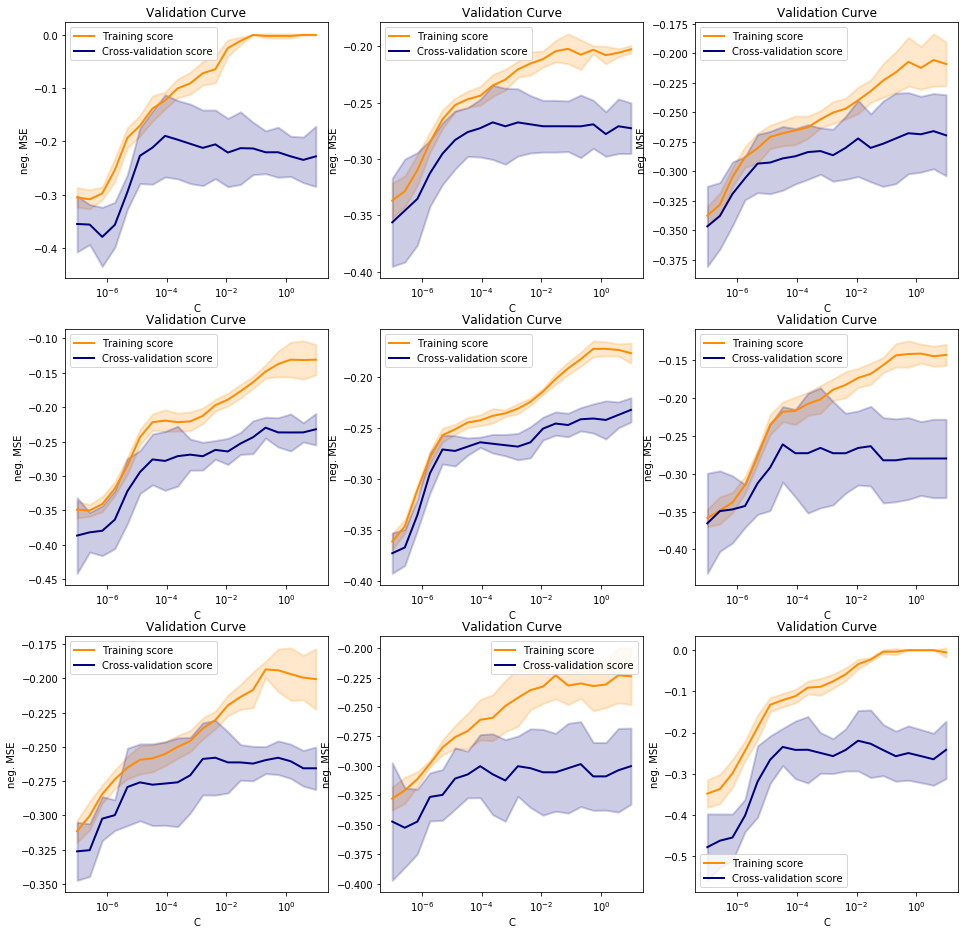

In [22]:
param_range = np.logspace(-7, 1, 20)
param_name = "C"

plt.figure(figsize=(16,16))
cvresults = {}
for x in range(1,10):
    model = linear_model.LogisticRegression(penalty="l2")
    cvresults[x] = crossValidate(model, xtrain2.iloc[trainindices[x]], ytrainBalanced[x],
                                param_name, param_range,subplotidx = (330 + x))
plt.show()

In [76]:
df=pd.DataFrame([pd.Series(cvresults[i][2].round(decimals = 2)) for i in range(1,10)])
df.columns = convertNPtoString(np.logspace(-7, 1, 20))
display(df.iloc[:,5:-1])

,1.274e-05,3.360e-05,8.859e-05,2.336e-04,6.158e-04,1.624e-03,4.281e-03,1.129e-02,2.976e-02,7.848e-02,2.069e-01,5.456e-01,1.438e+00,3.793e+00
0,-0.23,-0.21,-0.19,-0.20,-0.20,-0.21,-0.21,-0.22,-0.21,-0.21,-0.22,-0.22,-0.23,-0.23
1,-0.28,-0.28,-0.27,-0.27,-0.27,-0.27,-0.27,-0.27,-0.27,-0.27,-0.27,-0.27,-0.28,-0.27
2,-0.29,-0.29,-0.29,-0.28,-0.28,-0.29,-0.28,-0.27,-0.28,-0.28,-0.27,-0.27,-0.27,-0.27
3,-0.29,-0.28,-0.28,-0.27,-0.27,-0.27,-0.26,-0.26,-0.25,-0.24,-0.23,-0.24,-0.24,-0.24
4,-0.27,-0.27,-0.26,-0.27,-0.27,-0.27,-0.26,-0.25,-0.25,-0.25,-0.24,-0.24,-0.24,-0.24
5,-0.29,-0.26,-0.27,-0.27,-0.27,-0.27,-0.27,-0.27,-0.26,-0.28,-0.28,-0.28,-0.28,-0.28
6,-0.28,-0.28,-0.28,-0.28,-0.27,-0.26,-0.26,-0.26,-0.26,-0.26,-0.26,-0.26,-0.26,-0.27
7,-0.31,-0.31,-0.30,-0.31,-0.31,-0.30,-0.30,-0.31,-0.31,-0.30,-0.30,-0.31,-0.31,-0.30
8,-0.27,-0.24,-0.24,-0.24,-0.25,-0.26,-0.24,-0.22,-0.23,-0.24,-0.26,-0.25,-0.26,-0.26


### L1

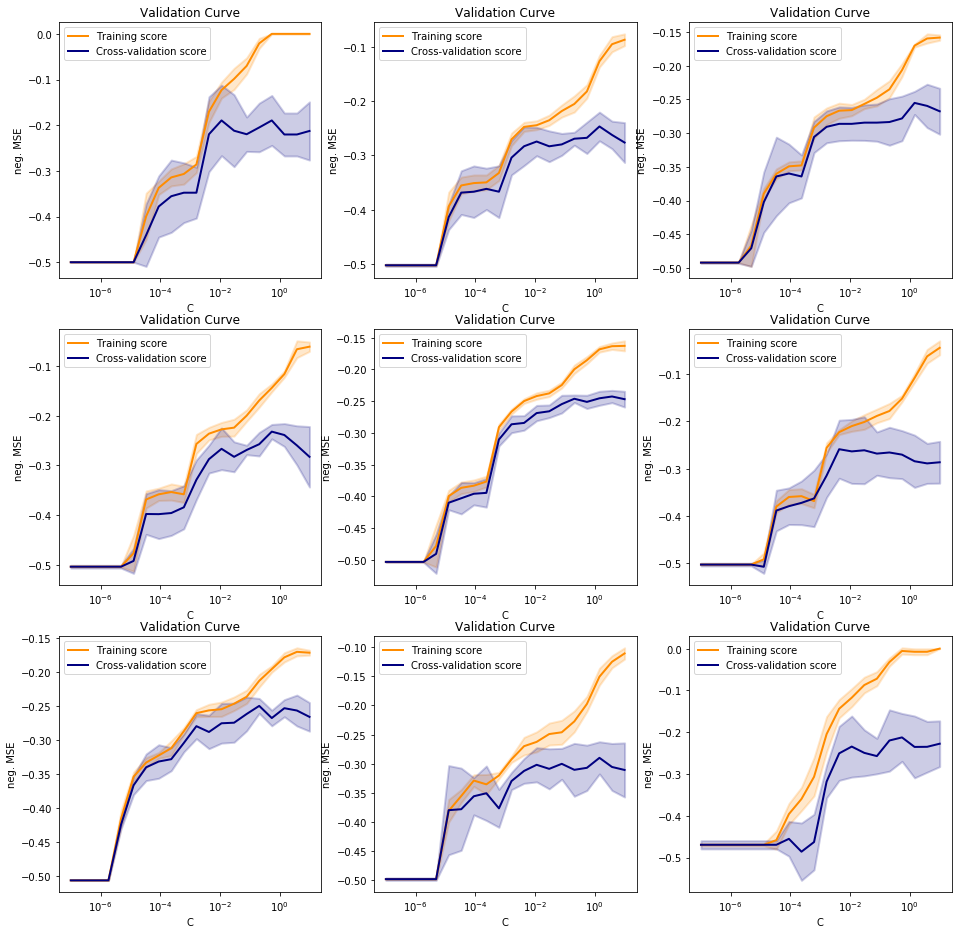

In [25]:
param_range = np.logspace(-7, 1, 20)
param_name = "C"

plt.figure(figsize=(16,16))
cvresults2 = {}
for x in range(1,10):
    model = linear_model.LogisticRegression(penalty="l1")
    cvresults2[x] = crossValidate(model, xtrain2.iloc[trainindices[x]], ytrainBalanced[x],
                                param_name, param_range,subplotidx = (330 + x))
plt.show()

In [26]:
df=pd.DataFrame([pd.Series(cvresults2[i][2].round(decimals = 2)) for i in range(1,10)])
df.columns = convertNPtoString(param_range)
display(df.iloc[:,5:-3])

,1.274e-05,3.360e-05,8.859e-05,2.336e-04,6.158e-04,1.624e-03,4.281e-03,1.129e-02,2.976e-02,7.848e-02,2.069e-01,5.456e-01
0,-0.50,-0.44,-0.38,-0.36,-0.35,-0.35,-0.22,-0.19,-0.21,-0.22,-0.20,-0.19
1,-0.41,-0.37,-0.37,-0.36,-0.37,-0.30,-0.28,-0.27,-0.28,-0.28,-0.27,-0.27
2,-0.40,-0.36,-0.36,-0.36,-0.31,-0.29,-0.29,-0.29,-0.28,-0.28,-0.28,-0.28
3,-0.49,-0.40,-0.40,-0.40,-0.38,-0.33,-0.29,-0.27,-0.28,-0.27,-0.26,-0.23
4,-0.41,-0.40,-0.40,-0.39,-0.31,-0.29,-0.28,-0.27,-0.27,-0.25,-0.25,-0.25
5,-0.51,-0.39,-0.38,-0.37,-0.36,-0.31,-0.26,-0.26,-0.26,-0.27,-0.27,-0.27
6,-0.37,-0.34,-0.33,-0.33,-0.30,-0.28,-0.29,-0.27,-0.27,-0.26,-0.25,-0.27
7,-0.38,-0.38,-0.36,-0.35,-0.38,-0.33,-0.31,-0.30,-0.31,-0.30,-0.31,-0.31
8,-0.47,-0.47,-0.46,-0.49,-0.46,-0.32,-0.25,-0.23,-0.25,-0.26,-0.22,-0.21


In [34]:
df=pd.DataFrame([pd.Series((np.max(cvresults2[i][2])-np.max(cvresults[i][2])).round(decimals = 2)) for i in range(1,10)])
df.columns = ["L1 best - L2 best"]
display(df)

,L1 best - L2 best
0,0.00
1,0.02
2,0.01
3,-0.00
4,-0.01
5,0.00
6,0.01
7,0.01
8,0.01


L1 and L2 regularization have similar performance

In [4]:
#picking best regularization strength for each i using L2
regstrengths = [2e-4, 
                9e-5,
                6e-4, 
                1e-2,
                3e-5, 
                3e-5,
                3e-2,
                2e-4,
                2e-4]


In [5]:
#making a logistic model as done above where a seperate logistic function is used for each ytrain dimension
#L2 regularization will be used with the strengths chosen by CV above

logisticmodel = ndlogistic(9, cvector = regstrengths, penalty = 'l2')
logisticmodel.train(xtrain2, trainindices[1:10], ytrainBalanced[1:10])
trainpreds = logisticmodel.predict(xtrain2, trainindices[1:10])
valpreds = logisticmodel.predict(xtrain2, valindices[1:10])

In [79]:
print("MSE value for each dimension 1 through 9 in stability vector")
for x in range(len(trainpreds)):
    print( "train MSE: ",
     mean_squared_error(ytrainBalanced[x + 1], trainpreds[x]), 
          "validation MSE: ", mean_squared_error(yvalBalanced[x + 1], valpreds[x]))
print("average train MSE over dimensions: ", np.mean([mean_squared_error(ytrainBalanced[x + 1], trainpreds[x]) 
                                                    for x in range(len(trainpreds))]))
print("average validation MSE over dimensions: ", np.mean([mean_squared_error(yvalBalanced[x + 1], valpreds[x]) 
                                                    for x in range(len(trainpreds))]))

MSE value for each dimension 1 through 9 in stability vector
train MSE:  0.11363636363636363 validation MSE:  0.06818181818181818
train MSE:  0.24305555555555555 validation MSE:  0.3020833333333333
train MSE:  0.25177304964539005 validation MSE:  0.2765957446808511
train MSE:  0.19080459770114944 validation MSE:  0.2
train MSE:  0.2491178546224418 validation MSE:  0.23890063424947147
train MSE:  0.2331002331002331 validation MSE:  0.3076923076923077
train MSE:  0.2143467122117848 validation MSE:  0.23529411764705882
train MSE:  0.2586805555555556 validation MSE:  0.24479166666666666
train MSE:  0.10606060606060606 validation MSE:  0.20454545454545456
average train MSE over dimensions:  0.20673061423212
average validation MSE over dimensions:  0.23089834188855132


The validation and test errors are equivalent.
The models has some degree of overfitting, but the accuracy is primarily limited by training accuracy
A more flexible model or additional feature generation could resolve this

## Evaluating on test set

In [11]:
trainpreds = logisticmodel.predict(xtrain2)
testpreds = logisticmodel.predict(xtest2)

print("MSE train",mean_squared_error(trainpreds, ytrain[:,1:10]))
print("MSE test",mean_squared_error(testpreds, ytest[:,1:10]))
print("precission test",precision_score(testpreds.flatten(), ytest[:,1:10].flatten()))
print("recall test",recall_score(testpreds.flatten(), ytest[:,1:10].flatten()))
logdict = {"logistic":[mean_squared_error(trainpreds, ytrain[:,1:10]),
                        mean_squared_error(testpreds, ytest[:,1:10]),
                       precision_score(testpreds.flatten(), ytest[:,1:10].flatten()),
                       recall_score(testpreds.flatten(), ytest[:,1:10].flatten())]
                                                                                    }
pSave(logdict,"logreg")

MSE train 0.2688807884433644
MSE test 0.26757369614512466
precission test 0.8218623481781376
recall test 0.2607578676942839


Test set has similar accuracy to the validation set.